In [1]:
import os, sys, django
os.environ.setdefault('DJANGO_SETTING_MODULE', 'deep-diary.settings')
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"  # 不增加这个就会报异步错误
django.setup()

In [2]:
from library.models import Img
from face.models import Face, FaceAlbum
from insightface.app import FaceAnalysis
import numpy as np
from deep_diary.settings import FACE_ROOT, FACE_INFO_ROOT

In [4]:
def get_people_fts(name):
    faces = Face.objects.filter(det_method=True, name=name)
#     print(faces)
    fts = np.array([])
    for i in range(len(faces)):
        fc_info = np.load(faces[i].face_info.path, allow_pickle=True)
        ft = fc_info.item().normed_embedding.reshape(1, -1)
#         print(ft.shape)
        fts=ft if i==0 else np.concatenate((fts, ft), axis=0)

    if fts.ndim == 2:  # fts 有数据，ndim是2
        cft = fts.mean(axis=0).reshape(1, -1)  # 将数组a转化为行向量
        return fts, cft
    else: # fts 无数据，ndim是1
        return None, None
        

# fts, cft = get_people_fts('blue')
# print(fts.ndim)
# print(cft.shape)

In [155]:
def save_calc_feats(face):
    if not face.face_info:
        return
    info_path = face.face_info.path
    fc_info = np.load(info_path, allow_pickle=True)
    ft = fc_info.item().normed_embedding.reshape(1, -1)
    
    fold = os.path.dirname(face.face_info.path)  # 保存该人的所有人脸特征
    all_fts_pth = os.path.join(fold, 'all_feats.txt')
    center_fts_pth = os.path.join(fold, 'center_feats.txt')
    if os.path.exists(all_fts_pth):
        all_fts = np.loadtxt(all_fts_pth, delimiter=',', dtype=float, skiprows=0, comments='#')  # 加载现有的所有人脸特征
        if all_fts.ndim == 1:  # 如果是一维数据，则转换成行向量
            all_fts = all_fts.reshape(1, -1)
        print(f'INFO all_fts shape is {all_fts.shape}, fc_info.normed_embedding shape is {ft.shape}')
        new_all_fts = np.concatenate((all_fts, ft), axis=0)
    else:
        new_all_fts = ft
    np.savetxt(all_fts_pth, new_all_fts, delimiter=',', fmt='%.4f')  # 保存该人的所有人脸特征

    center_fts = new_all_fts.mean(axis=0).reshape(1, -1)   #将数组a转化为行向量
    np.savetxt(center_fts_pth, center_fts, delimiter=',', fmt='%.4f')  # 保存该人中心特征向量，后续改为网络模型计算中心特征

In [5]:
def get_all_fts():
    names = []  # 保存所有人脸名字

    albums = FaceAlbum.objects.filter(is_has_feat=True)
#     print(albums)
    all_fts = np.array([])
    for i in range(len(albums)):
        # names.append(album.name)

        fts, cft = get_people_fts(albums[i].name)
        if fts is not None:
            names = np.append(names, albums[i].name)
            all_fts=cft if i==0 else np.concatenate((all_fts, cft), axis=0)
    return names, all_fts

# names, all_fts = get_all_fts()
# print(f'INFO names is {names}')
# print(f'INFO all_fts is {all_fts}')

In [11]:
def get_face_name(ft, based='os'):
    if based == 'os':
        combined_fts_pth = os.path.join(FACE_INFO_ROOT, 'combined_feats.txt')
        names_pth = os.path.join(FACE_INFO_ROOT, 'names.txt')
        if os.path.exists(combined_fts_pth):
            all_fts = np.loadtxt(combined_fts_pth, delimiter=',', dtype=float, skiprows=0, comments='#')  # 加载现有的所有人脸特征
            if all_fts.ndim == 1:  # 如果是一维数据，则转换成行向量
                all_fts = all_fts.reshape(1, -1)
        if os.path.exists(names_pth):
            names = np.loadtxt(names_pth, delimiter=',', dtype=str, skiprows=0, comments='#')  # 加载现有的所有人名
            print(names.shape)

    if based == 'database':
        names, all_fts = get_all_fts()  # 得到所有的人名和中心向量

    print(f'INFO names is {names[0]}')
    print(f'INFO all_fts.shape is {all_fts.shape}')

    sims = np.matmul(all_fts, ft.T)
    print(f'INFO sims is {sims[0]}')
    idx = sims.argmax()
    print(f'INFO idx is {idx}')
    print(f'INFO name is {names[idx]}, sim is {sims[idx]}')
    return names[idx], sims[idx]


name='mum'
face = Face.objects.filter(det_method=True, name=name).first()
ft = np.load(face.face_info.path, allow_pickle=True)
ft = ft.item().normed_embedding.reshape(1, -1)  # 得到特征向量
# print(f'INFO ft.shape is {ft}')
name,sim =  get_face_name(ft)

    
print(f'INFO names is {name}')
print(f'INFO all_fts is {sim}')



(2,)
INFO names is allison
INFO all_fts.shape is (2, 512)
INFO sims is [0.07146305]
INFO idx is 1
INFO name is mum, sim is [0.99995539]
INFO names is mum
INFO all_fts is [0.99995539]


In [47]:

print(center_feats.transpose().shape)
sims = np.matmul(all_feats, center_feats.T)
print(sims.shape)
print(sims)

new_all_feats=np.concatenate((all_feats,all_feats),axis=0)
print(new_all_feats.shape)
new_center_feats=np.concatenate((center_feats,center_feats),axis=0)
print(new_center_feats.shape)

NameError: name 'center_feats' is not defined

In [4]:
albums = FaceAlbum.objects.filter(is_has_feat=True)
for album in albums:
    print(f'INFO name is {album.name}, face_feat is {album.face_feat.path}')
#     center_feats = np.loadtxt(os.path.join(fold,'center_feats.txt'),  delimiter=',', dtype=float, skiprows=0, comments='#').reshape(1,-1)
# print(all_feats.ndim)


INFO name is allison, face_feat is D:\BlueDoc\deep_diary\media\face_info\allison\center_feats.txt
INFO name is mum, face_feat is D:\BlueDoc\deep_diary\media\face_info\mum\center_feats.txt
INFO name is mothers, face_feat is D:\BlueDoc\deep_diary\media\face_info\mothers\center_feats.txt
INFO name is susan, face_feat is D:\BlueDoc\deep_diary\media\face_info\susan\center_feats.txt


In [32]:
    names = []  # 保存所有人脸名字

    albums = FaceAlbum.objects.filter(is_has_feat=True)
    combined_fts_pth = os.path.join(FACE_INFO_ROOT, 'combined_feats.txt')
    names_pth = os.path.join(FACE_INFO_ROOT, 'names.txt')
    all_fts = np.zeros((1, 512))
    print(f'INFO combined_fts_pth do not existed, creating now...')

    for album in albums:
        names.append(album.name)
        center_ft = np.loadtxt(album.face_feat.path, delimiter=',', dtype=float, skiprows=0,
                               comments='#').reshape(1, -1)
        if all_fts.max() == 0:  # 初始化状态
            all_fts = center_ft
        else:
            all_fts = np.concatenate((all_fts, center_ft), axis=0)
    print(f'INFO names is {names}, feats is {all_fts.shape}')

    np.savetxt(combined_fts_pth, all_fts, delimiter=',', fmt='%.4f')  # 保存所有人脸特征
    np.savetxt(names_pth, names, delimiter=',', fmt='%s')  # 保存所有人对应人名

INFO combined_fts_pth do not existed, creating now...
INFO names is ['allison', 'mum', 'mothers', 'susan'], feats is (4, 512)


In [40]:
album = albums = FaceAlbum.objects.filter(name='allison').first()
print(album.name)

allison


In [48]:
def save_combined_feats():  # 保存所有人脸的中心特征

    names = []  # 保存所有人脸名字

    albums = FaceAlbum.objects.filter(is_has_feat=True)
    combined_fts_pth = os.path.join(FACE_INFO_ROOT, 'combined_feats.txt')
    names_pth = os.path.join(FACE_INFO_ROOT, 'names.txt')
    all_fts = np.zeros((1, 512))
    print(f'INFO combined_fts_pth do not existed, creating now...')

    for album in albums:
        names.append(album.name)
        center_ft = np.loadtxt(album.face_feat.path, delimiter=',', dtype=float, skiprows=0,
                               comments='#').reshape(1, -1)
        if all_fts.max() == 0:  # 初始化状态
            all_fts = center_ft
        else:
            all_fts = np.concatenate((all_fts, center_ft), axis=0)
    print(f'INFO names is {names}, feats is {all_fts.shape}')

    np.savetxt(combined_fts_pth, all_fts, delimiter=',', fmt='%.4f')  # 保存所有人脸特征
    np.savetxt(names_pth, names, delimiter=',', fmt='%s')  # 保存所有人对应人名

In [49]:
def update_combined_feats(album):  # 保存所有人脸的中心特征
    combined_fts_pth = os.path.join(FACE_INFO_ROOT, 'combined_feats.txt')
    center_ft = np.loadtxt(album.face_feat.path, delimiter=',', dtype=float, skiprows=0,
                           comments='#').reshape(1, -1)

    if os.path.exists(combined_fts_pth):
        all_fts = np.loadtxt(combined_fts_pth, delimiter=',', dtype=float, skiprows=0, comments='#')  # 加载现有的所有人脸特征
        if all_fts.ndim == 1:  # 如果是一维数据，则转换成行向量
            all_fts = all_fts.reshape(1, -1)
        all_fts = np.concatenate((all_fts, center_ft), axis=0)
        print(f'INFO all_fts already existed, the shape is {all_fts.shape}')
    else:
        all_fts = center_ft
        print(f'INFO combined_fts_pth do not existed, creating now...')

    names_pth = os.path.join(FACE_INFO_ROOT, 'names.txt')
    if os.path.exists(names_pth):
        names = np.loadtxt(names_pth, delimiter=',', dtype=str, skiprows=0, comments='#')  # 加载现有的所有人脸特征
    else:
        names = []
    names = np.append(names, album.name)
    print(f'INFO names is {names}')

    np.savetxt(combined_fts_pth, all_fts, delimiter=',', fmt='%.4f')  # 保存所有人脸特征
    np.savetxt(names_pth, names, delimiter=',', fmt='%s')  # 保存所有人对应人名

In [54]:
album = FaceAlbum.objects.filter(name='allison').first()
update_combined_feats(album)

INFO all_fts already existed, the shape is (3, 512)
INFO names is ['allison' 'allison' 'allison']


In [ ]:
from pyexiv2 import Image as Image_pyexiv2
import cv2 as cv

# encoding: utf-8
def compute_IOU(rec1, rec2):
    """
    计算两个矩形框的交并比。
    :param rec1: (x0,y0,x1,y1)      (x0,y0)代表矩形左上的顶点，（x1,y1）代表矩形右下的顶点。下同。
    :param rec2: (x0,y0,x1,y1)
    :return: 交并比IOU.
    """
    left_column_max = max(rec1[0], rec2[0])
    right_column_min = min(rec1[2], rec2[2])
    up_row_max = max(rec1[1], rec2[1])
    down_row_min = min(rec1[3], rec2[3])
    # 两矩形无相交区域的情况
    if left_column_max >= right_column_min or down_row_min <= up_row_max:
        return 0
    # 两矩形有相交区域的情况
    else:
        S1 = (rec1[2] - rec1[0]) * (rec1[3] - rec1[1])
        S2 = (rec2[2] - rec2[0]) * (rec2[3] - rec2[1])
        S_cross = (down_row_min - up_row_max) * (right_column_min - left_column_max)
        return S_cross / (S1 + S2 - S_cross)


def face_zoom(area, ratio, width, height):  # area: 中心坐标，宽度，高度
    [x, y, w, h] = area

    w = w * ratio
    h = h * ratio
    x1 = max(x - w / 2, 0)
    y1 = max(y - h / 2, 0)
    x2 = min(x1 + w, 1)
    y2 = min(y1 + h, 1)
    bbox = [x1 * width, y1 * height, x2 * width, y2 * height]
    return bbox  # 这里的bbox 还是浮点型，后续保存图片的时候同意转换
    # return np.array(bbox).astype(int)
    
# 通过LightRoom人脸识别的方式，保存相关人脸信息
def get_LM_face_info(img):
    print(f'INFO: get_LM_face_info ... ')
    num = 1  # xmp 内容下表从1开始
    is_have_face = True

    exiv_info = Image_pyexiv2(img.image.path)  # 登记图片路径
    xmp = exiv_info.read_xmp()  # 读取元数据，这会返回一个字典
    names = []
    bboxs = []
    while is_have_face:
        print(f'INFO: LM face detected')
        item = 'Xmp.mwg-rs.Regions/mwg-rs:RegionList[{:d}]/mwg-rs:Type'.format(num)
        is_have_face = xmp.get(item)
        if is_have_face:
            idx_name = 'Xmp.mwg-rs.Regions/mwg-rs:RegionList[{:d}]/mwg-rs:Name'.format(num)
            idx_h = 'Xmp.mwg-rs.Regions/mwg-rs:RegionList[{:d}]/mwg-rs:Area/stArea:h'.format(num)
            idx_w = 'Xmp.mwg-rs.Regions/mwg-rs:RegionList[{:d}]/mwg-rs:Area/stArea:w'.format(num)
            idx_x = 'Xmp.mwg-rs.Regions/mwg-rs:RegionList[{:d}]/mwg-rs:Area/stArea:x'.format(num)
            idx_y = 'Xmp.mwg-rs.Regions/mwg-rs:RegionList[{:d}]/mwg-rs:Area/stArea:y'.format(num)
            num += 1

            name = xmp.get(idx_name, 'unknown')
            names.append(name)
            lm_face_area = [xmp.get(idx_x), xmp.get(idx_y), xmp.get(idx_w), xmp.get(idx_h)]  # 0~1 之间的字符
            lm_face_area = np.array(lm_face_area).astype(float)  # 0~1 之间的浮点，中心区域，人脸长，宽
            bbox = face_zoom(lm_face_area, 1, img.image.width, img.image.height)  # 转变成像素值，左上区域和右下区域坐标，跟insightface 保持一致
            bboxs.append(bbox)

    return names, bboxs



INFO: get_LM_face_info ... 
INFO: LM face detected
INFO: LM face detected
INFO: LM face detected
INFO: LM face detected
INFO: LM face detected
INFO names is ['老妈', 'allison', 'susan', '丈母娘']
INFO bboxs is [[1751.98208, 312.00848, 2035.99872, 596.00912], [1964.0115199999998, 671.99776, 2227.9987199999996, 936.0064], [1255.9974399999999, 800.00368, 1627.99616, 1172.0072], [2508.02176, 916.0048800000001, 2832.0153600000003, 1240.00856]]
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Blue/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Blue/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Blue/.insightface\models\buffalo_l\det_10g.onnx 

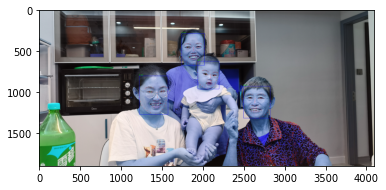

In [15]:
from matplotlib import pyplot as plt
%matplotlib inline
# 测试人脸及图片
name='allison'
face = Face.objects.filter(det_method=True, name=name).last()
img=face.img


names, bboxs = get_LM_face_info(img)
print(f'INFO names is {names}')
print(f'INFO bboxs is {bboxs}')

app = FaceAnalysis(providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))
image_path = img.image.path

img = cv.imread(image_path)  # 自己用openCV进行读取
faces = app.get(img)
rimg = app.draw_on(img, faces)
plt.imshow(rimg)
plt.show()
# for i in range(len(faces)):
#     ious=np.array([])
#     for bbox in bboxs:
#         iou = compute_IOU(bbox, faces[i].bbox)
#         ious = np.append(ious, iou)
#     idx = ious.argmax()
#     face_name = names[idx]
#     print(f'INFO ious is {ious}')
#     print(f'estimated name is {face_name}, which is from LM')

In [51]:
faces = get_people_fts('allison')
print(type(faces))

<class 'tuple'>


In [48]:
a=[]
print(len(a))
b=[1,2,3,4]
c=[3,3,3,3]
a.append(b)
a.append(c)
print(a)
print(len(a))
a=[]
a = np.append(a,b)
a = np.append(a,c)
print(a)
print(len(a))

0
[[1, 2, 3, 4], [3, 3, 3, 3]]
2
[1. 2. 3. 4. 3. 3. 3. 3.]
8
